In [139]:
%matplotlib inline
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

In [153]:
#prepare for deleting comment lines: define function organize, in_str as the cell of original code, output the code without comment lines
def organize(in_str):
    def rm_enter(str_in,tmp):
        par = str_in.partition("\r\n")
        tmp += [par[0]]
        if par[-1].find("\r\n") == -1:
            tmp += [par[-1]]
            return tmp
        else:
            return rm_enter(par[-1], tmp)
    no_enter = rm_enter(in_str,[])
    organized=""
    for line in no_enter:
        if line.find("#")!=-1:
            line = line.partition('#')[0]
            if line != "\t":
                organized+=line+"\n"
        else:       
            organized+=line+"\n"
    return organized[:-1]

In [159]:
#delete comment lines of each code
#output dataframe: comment_df
comment_df = pd.read_csv("./CodeStates/CodeState.csv")
for i in range(len(comment_df)):
    if i != 1023:
        #print(i)
        f = comment_df["Code"].iloc[i]
        comment_df["Code"].iloc[i] = organize(f)

In [160]:
#only CodeStateID = 1024 is NA, generate all other codes to .py seperately
for i in range(1,2371):
    if i != 1024:
        with open("./pys_WatWin/hw_" + str(i) + ".py","w") as myfile:
            myfile.write(comment_df["Code"][i-1])

In [138]:
#write windows .bat file to run each .py automatically and output stderr to .txt files
#need to manually execute this .bat file from directory
with open("run.bat", "w") as myfile:
    for i in range(1,2371):
        if i != 1024:
            myfile.write("python hw_" + str(i) + ".py > result_" + str(i) + ".txt 2>&1 \n")

In [294]:
#input result file to list 
results = {}

for i in range(1,2371):
    if i != 1024:
        with open("./pys_WatWin/result_" + str(i) + ".txt", "r") as myfile:
            results[i] = "".join(myfile.readlines())

In [162]:
#convert list into pandas dataframe
#output dataframe: results_df
results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Code"])

In [296]:
#generate "IsErr, ErrLoc, ErrType", ErrLineLoc, ErrLine" attributes
results_df["IsErr"] = ["No" if i.find("Error")==-1 else "Yes" for i in results_df["Code"]]

results_df["ErrLoc"] = [i.find("Error") if i.find("Error")!=-1 else np.nan for i in results_df["Code"]]

results_df["ErrType"] = [results_df["Code"][i][int(results_df["ErrLoc"][i])-15:int(results_df["ErrLoc"][i])] if results_df["IsErr"][i]=="Yes" else "N/A" for i in range(1,1024)+range(1025,2371)]

results_df["ErrType"] = [i[int(re.search(r'^([^A-Z]*[A-Z]){1}',i).span()[1])-1:] if i!="N/A" else "N/A" for i in results_df["ErrType"]]

results_df["ErrLineLoc"] = [results_df["Code"][i].find("line") if results_df["IsErr"][i] == "Yes" else "N/A" for i in range(1,1024)+range(1025,2371)]

results_df["ErrLine"] = [results_df["Code"][i][results_df["ErrLineLoc"][i]+4:results_df["ErrLineLoc"][i]+7].replace("\n","") if results_df["IsErr"][i]=="Yes" else np.nan for i in range(1,1024)+range(1025,2371)]


In [164]:
#save error information to .csv
results_df.to_csv("CodeErrorInfo_woComment.csv")

In [180]:
#open main_table and input "IsErr, ErrType, ErrLine" attributes to column
main_table_df = pd.read_csv("MainTable.csv")

main_table_df["IsErr"] = [results_df["IsErr"][i] if i!=1024 else "NO_SUBMISSION" for i in main_table_df["CodeStateID"]]

main_table_df["ErrType"] = [results_df["ErrType"][i] if i!=1024 else "NO_SUBMISSION" for i in main_table_df["CodeStateID"]]

main_table_df["ErrLine"] = [results_df["ErrLine"][i] if i!=1024 else "NO_SUBMISSION" for i in main_table_df["CodeStateID"]]



In [288]:
#time estimation: time_diff of (e_i,e_i+1) is written on e_i
#input dataframe main_table_df
import datetime
from datetime import timedelta

time_arr = {}
mean_dict = {}
std_dict = {}

for subj in set(main_table_df["SubjectID"].loc[main_table_df["EventType"]=="Submit"]):
    current_df = main_table_df.loc[main_table_df["SubjectID"] == subj]
    current_df = current_df[current_df["EventType"]=="Submit"]
    #print(current_df)
    #print(subj)
    sum_time = 0
    count_time = 0
    if len(current_df) > 1:
        time_arr[subj] = {}
        for i in range(len(current_df)-1):
            if current_df["CodeStateID"].iloc[i+1] != current_df["CodeStateID"].iloc[i]:
                if current_df["IsErr"].iloc[i] != "No":
                    datetimeFormat = '%Y-%m-%dT%H:%M:%S'
                    date1 = datetime.datetime.strptime(current_df["ServerTimestamp"].iloc[i+1], datetimeFormat)
                    date2 = datetime.datetime.strptime(current_df["ServerTimestamp"].iloc[i], datetimeFormat)
                    time_diff = ((((date1.month-date2.month)*30 + (date1.day-date2.day))*24 + (date1.hour-date2.hour))*60 + (date1.minute-date2.minute))*60 + (date1.second-date2.second)
                    #print(i)
                    #print(time_diff)
                    sum_time += time_diff
                    count_time = count_time+1
                    time_arr[subj][current_df["CodeStateID"].iloc[i]] = time_diff
#                     time_arr.append(time_diff)
                    
        if count_time != 0:
            mean_time = sum_time / count_time
            mean_dict[subj] = mean_time
            #print(mean_time)
            std_time = np.std(time_arr[subj].values())
            std_dict[subj] = std_time
            #print(std_time)
                       

In [291]:
#add TimeEst to main_table_df
main_table_df["TimeEst"] = [time_arr[main_table_df["SubjectID"][i]][main_table_df["CodeStateID"][i]] if main_table_df["SubjectID"][i] in time_arr.keys() and main_table_df["CodeStateID"][i] in time_arr[main_table_df["SubjectID"][i]].keys() else -1 for i in range(len(main_table_df))]
main_table_df["TimeMean"] = [mean_dict[i] if i in mean_dict.keys() else 0  for i in main_table_df["SubjectID"]]
main_table_df["TimeStd"] = [std_dict[i] if i in std_dict.keys() else 0  for i in main_table_df["SubjectID"]]

In [292]:
main_table_df

,EventType,EventID,Order,SubjectID,ToolInstances,CodeStateID,ServerTimestamp,ProblemID,Correct,IsErr,ErrType,ErrLine,TimeEst,TimeMean,TimeStd
0,Submit,f48cba2510087c502dde920d948b364b,1373,S002,ITAP; Python,1061,2016-02-05T19:46:00,nearestBusStop,True,No,N/A,NaN,-1,52,64.284869
1,Submit,93232279e317e6a46f6bdf001ab13a39,1374,S002,ITAP; Python,1062,2016-02-05T19:48:00,backwardsCombine,True,No,N/A,NaN,-1,52,64.284869
2,X-HintRequest,4468830a73173d348adbb2159ee9a0fa,1375,S002,ITAP; Python,1063,2016-02-05T19:49:00,firstAndLast,False,Yes,Indentation,4,-1,52,64.284869
3,X-HintRequest,2961b2aedf2483e7cf584a43aca4192e,1376,S002,ITAP; Python,1064,2016-02-05T19:50:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869
4,X-HintRequest,0f36ef933aaf49a51243ec78543a995d,1377,S002,ITAP; Python,1065,2016-02-05T19:51:00,firstAndLast,False,Yes,Indentation,3,-1,52,64.284869
5,X-HintRequest,5c70d95383a9140d5ff6ed5b1c164032,1378,S002,ITAP; Python,1066,2016-02-05T19:51:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869
6,X-HintRequest,4b7b63d2a540bc28aa9f1a7efa8437aa,1379,S002,ITAP; Python,1066,2016-02-05T19:52:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869
7,X-HintRequest,938c0a3c1517c59373c550ab59707a09,1380,S002,ITAP; Python,1067,2016-02-05T19:52:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869
8,Submit,21ec3c4beaf552084cad7b60350767a9,1381,S002,ITAP; Python,1068,2016-02-05T19:53:00,firstAndLast,False,Yes,Syntax,2,60,52,64.284869
9,Submit,d5f06ee0757f7c63be6aa1d9962b7df0,1382,S002,ITAP; Python,1069,2016-02-05T19:54:00,firstAndLast,False,Yes,Indentation,3,120,52,64.284869


In [300]:
#calculate WatWin
WatWin_dict = {}
err_df = pd.read_csv("CodeErrorInfo_woComment.csv")

for s in set(main_table_df["SubjectID"].loc[main_table_df["EventType"]=="Submit"]):
#     print s
    current_df = main_table_df.loc[main_table_df["SubjectID"] == s]
    current_df = current_df[current_df["EventType"]=="Submit"]
    score = 0
    if len(current_df) <= 1:
        WatWin = 0
    else:
        for i in range(len(current_df)-1):
            #remove identical pairs
            if current_df["CodeStateID"].iloc[i] != current_df["CodeStateID"].iloc[i+1]:
                #if former event has error
                if current_df["IsErr"].iloc[i] != "No":
                    #if later event has error
                    if current_df["IsErr"].iloc[i+1] != "No":
                        #if same full message
                        if err_df["Code"].iloc[i] == err_df["Code"].iloc[i+1]:
                            score += 4
                        #if same error type
                        if err_df["ErrType"].iloc[i] == err_df["ErrType"].iloc[i+1]:
                            score += 4
                        #if same line
                        if err_df["ErrLineLoc"].iloc[i] == err_df["ErrLineLoc"].iloc[i+1]:
                            score += 2
                        #if time < M - 1SD
                        if current_df["TimeEst"].iloc[i] < (current_df["TimeMean"].iloc[i] - current_df["TimeStd"].iloc[i]):
                            score += 1
                        else:
                            #if time > M - 1SD
                            if current_df["TimeEst"].iloc[i] > (current_df["TimeMean"].iloc[i] - current_df["TimeStd"].iloc[i]):
                                score += 25
                            else:
                                score += 15
                 #if later event does not have error
                 else:         
                    #if time < M - 1SD
                    if current_df["TimeEst"].iloc[i] < (current_df["TimeMean"].iloc[i] - current_df["TimeStd"].iloc[i]):
                        score += 1
                    else:
                         #if time > M - 1SD
                        if current_df["TimeEst"].iloc[i] > (current_df["TimeMean"].iloc[i] - current_df["TimeStd"].iloc[i]):
                            score += 25
                        else:
                            score += 15       
                            
                                
        WatWin = (score/35.)/(len(current_df)-1.)
        WatWin_dict[s] = WatWin

main_table_df["WatWin"] = [WatWin_dict[i] if i in WatWin_dict.keys() else 0  for i in main_table_df["SubjectID"]]

In [302]:
main_table_df

,EventType,EventID,Order,SubjectID,ToolInstances,CodeStateID,ServerTimestamp,ProblemID,Correct,IsErr,ErrType,ErrLine,TimeEst,TimeMean,TimeStd,WatWin
0,Submit,f48cba2510087c502dde920d948b364b,1373,S002,ITAP; Python,1061,2016-02-05T19:46:00,nearestBusStop,True,No,N/A,NaN,-1,52,64.284869,0.545813
1,Submit,93232279e317e6a46f6bdf001ab13a39,1374,S002,ITAP; Python,1062,2016-02-05T19:48:00,backwardsCombine,True,No,N/A,NaN,-1,52,64.284869,0.545813
2,X-HintRequest,4468830a73173d348adbb2159ee9a0fa,1375,S002,ITAP; Python,1063,2016-02-05T19:49:00,firstAndLast,False,Yes,Indentation,4,-1,52,64.284869,0.545813
3,X-HintRequest,2961b2aedf2483e7cf584a43aca4192e,1376,S002,ITAP; Python,1064,2016-02-05T19:50:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869,0.545813
4,X-HintRequest,0f36ef933aaf49a51243ec78543a995d,1377,S002,ITAP; Python,1065,2016-02-05T19:51:00,firstAndLast,False,Yes,Indentation,3,-1,52,64.284869,0.545813
5,X-HintRequest,5c70d95383a9140d5ff6ed5b1c164032,1378,S002,ITAP; Python,1066,2016-02-05T19:51:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869,0.545813
6,X-HintRequest,4b7b63d2a540bc28aa9f1a7efa8437aa,1379,S002,ITAP; Python,1066,2016-02-05T19:52:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869,0.545813
7,X-HintRequest,938c0a3c1517c59373c550ab59707a09,1380,S002,ITAP; Python,1067,2016-02-05T19:52:00,firstAndLast,False,No,N/A,NaN,-1,52,64.284869,0.545813
8,Submit,21ec3c4beaf552084cad7b60350767a9,1381,S002,ITAP; Python,1068,2016-02-05T19:53:00,firstAndLast,False,Yes,Syntax,2,60,52,64.284869,0.545813
9,Submit,d5f06ee0757f7c63be6aa1d9962b7df0,1382,S002,ITAP; Python,1069,2016-02-05T19:54:00,firstAndLast,False,Yes,Indentation,3,120,52,64.284869,0.545813


In [303]:
#save new table to MainTable_WatWin.csv
main_table_df.to_csv("MainTable_WatWin.csv")

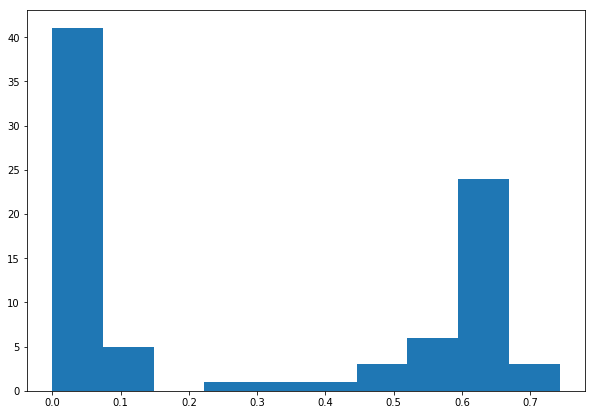

In [304]:
#generate EQ distribution
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111)
ax.hist(WatWin_dict.values())
plt.savefig("dist_WatWin.png", format="png")